# Import Libraries

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [22]:
def split_and_overwrite_city_state(df, column_names):
    """Splits columns like 'DEST_CITY' into 'dest_city' and 'dest_state' (no redundant naming)."""
    df = df.copy()
    
    for column_name in column_names:
        # Extract base name ('DEST' → 'dest')
        base_name = column_name.split('_')[0].lower()
        
        # Split city and state (e.g., "New York, NY" → ["New York", "NY"])
        split_result = df[column_name].str.split(r'\s*,\s*', n=1, expand=True)
        
        # Replace original column with clean city name
        df[column_name] = split_result[0].str.strip()
        
        # Add new state column
        df[f"{base_name}_state"] = split_result[1].str.strip()
    
    return df

def get_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] < lower) | (data[column] > upper)]

def add_weekday_weekend_columns(df, date_columns):
    """Adds weekday name, and weekend boolean for each date column.
    Args:
        df (pd.DataFrame): Input DataFrame.
        date_columns (list): List of column names containing dates.
    Returns:
        pd.DataFrame: DataFrame with added day-related columns.
    """
    df = df.copy()
    
    for col in date_columns:
        # Ensure column is in datetime format
        if not pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Add Day Name (e.g., 'Monday')
        df[f'{col}_day_name'] = df[col].dt.day_name()
        
        # Add Weekend Boolean (True if Saturday/Sunday)
        df[f'{col}_is_weekend'] = df[col].dt.dayofweek.isin([5, 6])  # 5=Sat, 6=Sun
    
    return df

In [23]:
# Download latest version
path = kagglehub.dataset_download("patrickzel/flight-delay-and-cancellation-data-2019-2023-v2")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\sivas\.cache\kagglehub\datasets\patrickzel\flight-delay-and-cancellation-data-2019-2023-v2\versions\3


In [24]:
dataset_path = r"C:\Users\sivas\.cache\kagglehub\datasets\patrickzel\flight-delay-and-cancellation-data-2019-2023-v2\versions\3"
import os

for file in os.listdir(dataset_path):
    print(file)


flights_sample_100k.csv
flights_sample_10k.csv
flights_sample_2m.csv


In [25]:
df_100 = pd.read_csv(os.path.join(dataset_path, "flights_sample_100k.csv"))
print(df_100.head())

      FL_DATE                 AIRLINE                 AIRLINE_DOT  \
0  2019-03-01           Allegiant Air           Allegiant Air: G4   
1  2021-02-16  American Airlines Inc.  American Airlines Inc.: AA   
2  2022-04-12       PSA Airlines Inc.       PSA Airlines Inc.: OH   
3  2021-10-13  Southwest Airlines Co.  Southwest Airlines Co.: WN   
4  2022-06-05  Southwest Airlines Co.  Southwest Airlines Co.: WN   

  AIRLINE_CODE  DOT_CODE  FL_NUMBER ORIGIN                     ORIGIN_CITY  \
0           G4     20368       1668    PGD                 Punta Gorda, FL   
1           AA     19805       2437    DFW           Dallas/Fort Worth, TX   
2           OH     20397       5560    EWN  New Bern/Morehead/Beaufort, NC   
3           WN     19393       1944    ABQ                 Albuquerque, NM   
4           WN     19393       3081    PIT                  Pittsburgh, PA   

  DEST        DEST_CITY  ...  DIVERTED  CRS_ELAPSED_TIME  ELAPSED_TIME  \
0  SPI  Springfield, IL  ...       0.0    

In [26]:
df_100['DELAY_STATUS'] = df_100['ARR_DELAY'].apply(lambda x: 0 if x<=15 else 1)
df_100['DELAY_STATUS'].value_counts()

DELAY_STATUS
0    79766
1    20234
Name: count, dtype: int64

In [27]:
df_100[df_100['CANCELLED'] == 1] #flights that got cancelled

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DELAY_STATUS
1,2021-02-16,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2437,DFW,"Dallas/Fort Worth, TX",LAX,"Los Angeles, CA",...,211.0,NaN,NaN,1235.0,NaN,NaN,NaN,NaN,NaN,1
105,2023-02-01,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,295,SAT,"San Antonio, TX",LAS,"Las Vegas, NV",...,175.0,NaN,NaN,1069.0,NaN,NaN,NaN,NaN,NaN,1
106,2020-12-30,Envoy Air,Envoy Air: MQ,MQ,20398,3975,MSP,"Minneapolis, MN",DFW,"Dallas/Fort Worth, TX",...,180.0,NaN,NaN,852.0,NaN,NaN,NaN,NaN,NaN,1
120,2021-10-31,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,61,YAK,"Yakutat, AK",CDV,"Cordova, AK",...,49.0,NaN,NaN,213.0,NaN,NaN,NaN,NaN,NaN,1
131,2019-06-17,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,1792,CVG,"Cincinnati, OH",DFW,"Dallas/Fort Worth, TX",...,147.0,NaN,NaN,812.0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99876,2022-04-02,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2399,FLL,"Fort Lauderdale, FL",DFW,"Dallas/Fort Worth, TX",...,203.0,NaN,NaN,1119.0,NaN,NaN,NaN,NaN,NaN,1
99878,2020-03-23,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,5939,SFO,"San Francisco, CA",MMH,"Mammoth Lakes, CA",...,78.0,NaN,NaN,193.0,NaN,NaN,NaN,NaN,NaN,1
99899,2020-09-01,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,878,DAL,"Dallas, TX",IND,"Indianapolis, IN",...,125.0,NaN,NaN,755.0,NaN,NaN,NaN,NaN,NaN,1
99920,2022-01-04,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,204,LAX,"Los Angeles, CA",SFO,"San Francisco, CA",...,90.0,NaN,NaN,337.0,NaN,NaN,NaN,NaN,NaN,1


In [28]:
delay_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 
               'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 
               'DELAY_DUE_LATE_AIRCRAFT']

df_100[delay_cols] = df_100[delay_cols].fillna(0)

In [29]:
df_100.isnull().sum()  #missing values

FL_DATE                        0
AIRLINE                        0
AIRLINE_DOT                    0
AIRLINE_CODE                   0
DOT_CODE                       0
FL_NUMBER                      0
ORIGIN                         0
ORIGIN_CITY                    0
DEST                           0
DEST_CITY                      0
CRS_DEP_TIME                   0
DEP_TIME                    2576
DEP_DELAY                   2577
TAXI_OUT                    2618
WHEELS_OFF                  2618
WHEELS_ON                   2655
TAXI_IN                     2655
CRS_ARR_TIME                   0
ARR_TIME                    2655
ARR_DELAY                   2852
CANCELLED                      0
CANCELLATION_CODE          97373
DIVERTED                       0
CRS_ELAPSED_TIME               0
ELAPSED_TIME                2852
AIR_TIME                    2852
DISTANCE                       0
DELAY_DUE_CARRIER              0
DELAY_DUE_WEATHER              0
DELAY_DUE_NAS                  0
DELAY_DUE_

# Using an AutoEDA

In [34]:
# pip install ydata-profiling -q

In [ ]:
# import pandas as pd
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df_100, title="Pandas Profiling Report")
# profile.to_file("output_report.json")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


# Data Preprocessing

After I went through the dataset, there are some columns that I think are not useful since our target is the Arrival delay time.

## Outlier detection and deletion

Some features have extreme outliers, here we decide to delete those outliers, especially in DEP_DELAY, TAXI_OUT, TAXI_IN,ARR_DELAY

## Scaling

Scaling will be executed if needed, since logically speaking, scaling wouldn't do any good, because our target, arrival delay will be affected.

In [40]:
# df['TAXI_IN'] = df['CRS_DEP_TIME'].apply(convert_time)
# df['TAXI_OUT'] = df['CRS_DEP_TIME'].apply(convert_time)

## Making 2 new columns, which are the States of destination and departure

In [30]:
df = split_and_overwrite_city_state(df_100, ['DEST_CITY', 'ORIGIN_CITY'])
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DELAY_STATUS,dest_state,origin_state
0,2019-03-01,Allegiant Air,Allegiant Air: G4,G4,20368,1668,PGD,Punta Gorda,SPI,Springfield,...,122.0,994.0,0.0,0.0,0.0,0.0,0.0,0,IL,FL
1,2021-02-16,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2437,DFW,Dallas/Fort Worth,LAX,Los Angeles,...,NaN,1235.0,0.0,0.0,0.0,0.0,0.0,1,CA,TX
2,2022-04-12,PSA Airlines Inc.,PSA Airlines Inc.: OH,OH,20397,5560,EWN,New Bern/Morehead/Beaufort,CLT,Charlotte,...,51.0,221.0,0.0,0.0,0.0,0.0,0.0,0,NC,NC
3,2021-10-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1944,ABQ,Albuquerque,DEN,Denver,...,49.0,349.0,10.0,0.0,0.0,0.0,6.0,1,CO,NM
4,2022-06-05,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3081,PIT,Pittsburgh,STL,St. Louis,...,82.0,554.0,0.0,0.0,0.0,0.0,0.0,0,MO,PA


## Making Weekdays, Weekends, and Days name from dates

In [31]:
df = add_weekday_weekend_columns(df, ['FL_DATE'])

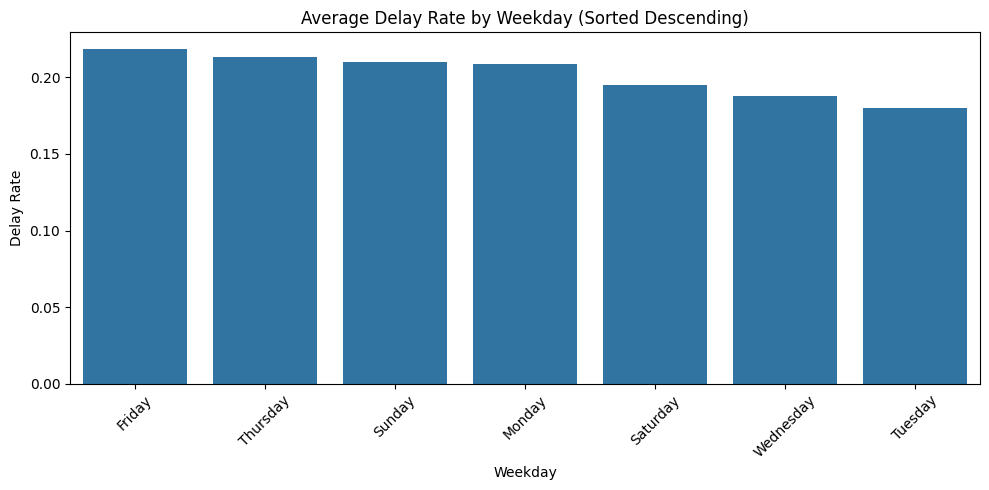

In [34]:
# Compute delay rate by weekday
weekday_delay = df.groupby('FL_DATE_day_name')['DELAY_STATUS'].mean()

# Sort by descending delay rate
weekday_delay_sorted = weekday_delay.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_delay_sorted.index, y=weekday_delay_sorted.values)
plt.title("Average Delay Rate by Weekday (Sorted Descending)")
plt.ylabel("Delay Rate")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.grid(False)  # Disable grid lines
plt.tight_layout()
plt.savefig("weekday_delay_rate.png", dpi=300)
plt.show()

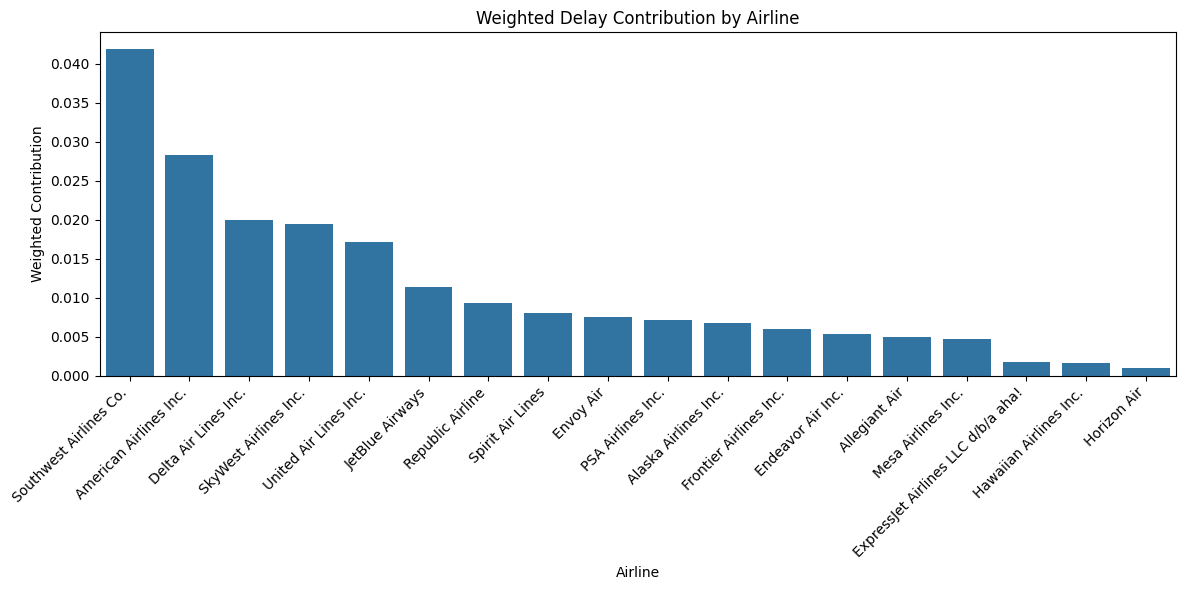

In [36]:
# Count number of flights and delays
flight_counts = df.groupby('AIRLINE')['DELAY_STATUS'].agg(['count', 'sum'])
flight_counts['delay_rate'] = flight_counts['sum'] / flight_counts['count']

# Normalize by total number of records (optional)
total_flights = flight_counts['count'].sum()
flight_counts['weight'] = flight_counts['count'] / total_flights

# Weighted delay contribution
flight_counts['weighted_delay_contribution'] = flight_counts['weight'] * flight_counts['delay_rate']

# Sort and plot
weighted = flight_counts.sort_values('weighted_delay_contribution', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=weighted.index, y=weighted['weighted_delay_contribution'])
plt.title("Weighted Delay Contribution by Airline")
plt.ylabel("Weighted Contribution")
plt.xlabel("Airline")
plt.xticks(rotation=45, ha='right')
plt.grid(False)

plt.tight_layout()
plt.savefig("airline_weighted_delay_contribution.png", dpi=300)
plt.show()


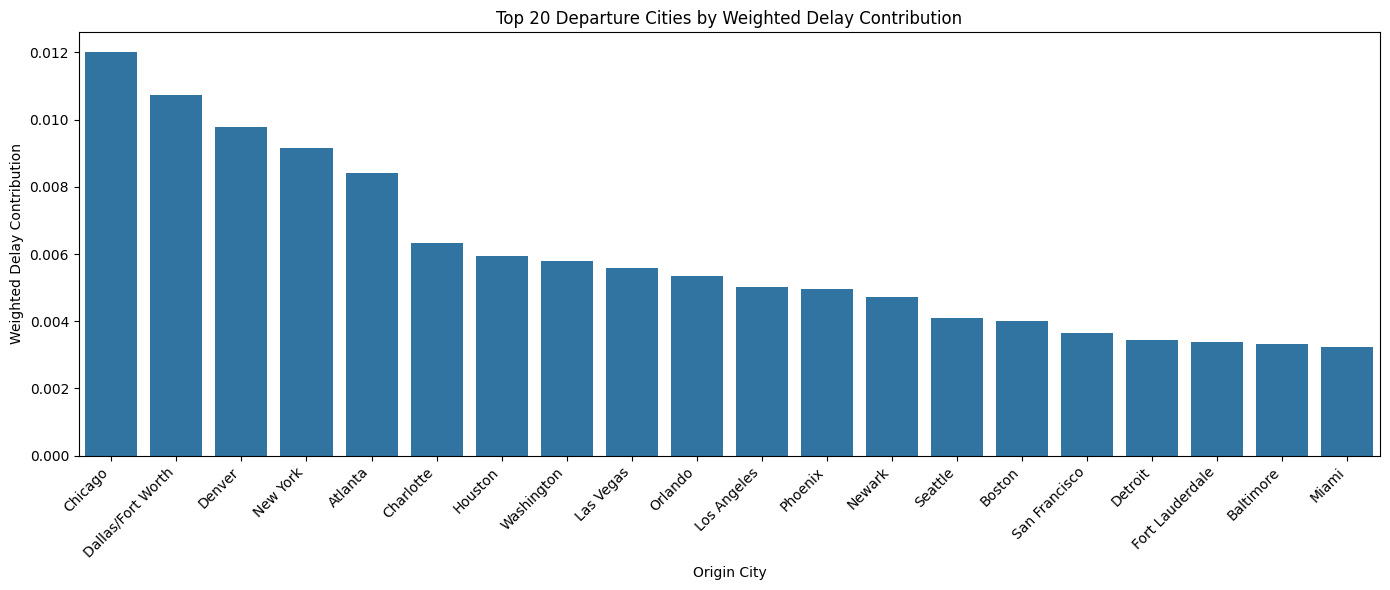

In [37]:
# Group by ORIGIN_CITY
origin_stats = df.groupby('ORIGIN_CITY')['DELAY_STATUS'].agg(['count', 'sum'])
origin_stats['delay_rate'] = origin_stats['sum'] / origin_stats['count']

# Weight by flight volume
origin_stats['weight'] = origin_stats['count'] / origin_stats['count'].sum()

# Weighted delay contribution
origin_stats['weighted_delay'] = origin_stats['weight'] * origin_stats['delay_rate']

# Sort by weighted contribution
origin_sorted = origin_stats.sort_values('weighted_delay', ascending=False).head(20)  # top 20 cities

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=origin_sorted.index, y=origin_sorted['weighted_delay'])
plt.title("Top 20 Departure Cities by Weighted Delay Contribution")
plt.ylabel("Weighted Delay Contribution")
plt.xlabel("Origin City")
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.savefig("weighted_delay_by_origin_city.png", dpi=300)
plt.show()


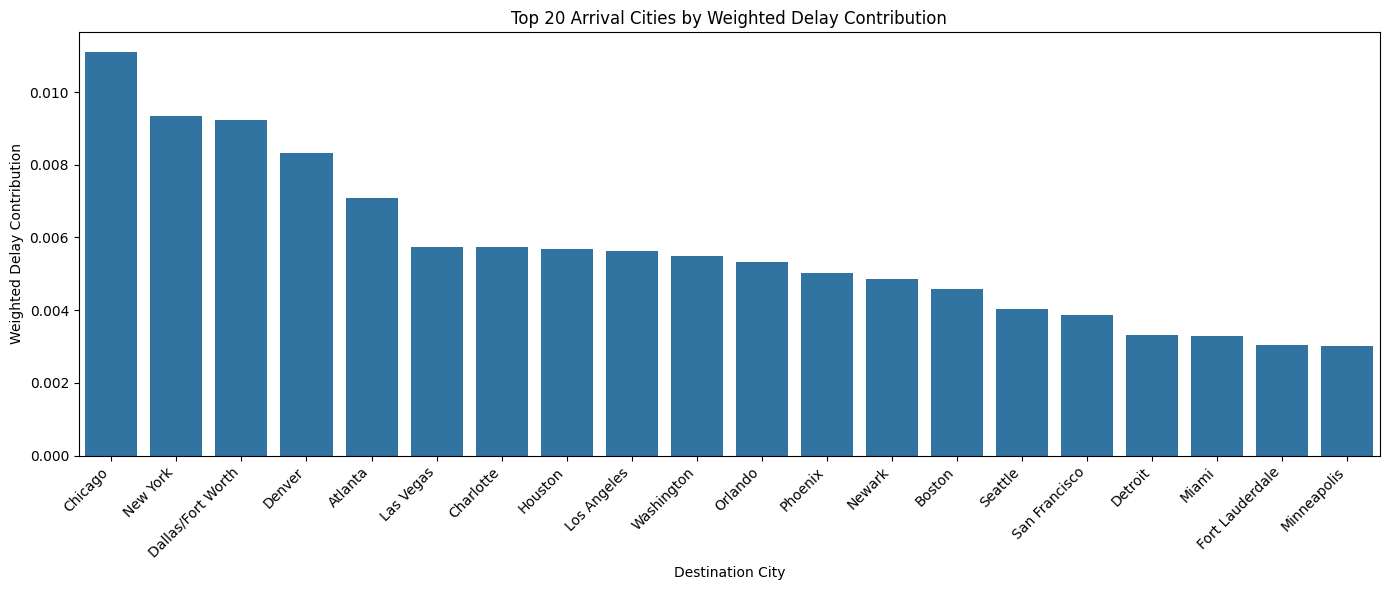

In [38]:
# Group by DEST_CITY
dest_stats = df.groupby('DEST_CITY')['DELAY_STATUS'].agg(['count', 'sum'])
dest_stats['delay_rate'] = dest_stats['sum'] / dest_stats['count']
dest_stats['weight'] = dest_stats['count'] / dest_stats['count'].sum()
dest_stats['weighted_delay'] = dest_stats['weight'] * dest_stats['delay_rate']

dest_sorted = dest_stats.sort_values('weighted_delay', ascending=False).head(20)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=dest_sorted.index, y=dest_sorted['weighted_delay'])
plt.title("Top 20 Arrival Cities by Weighted Delay Contribution")
plt.ylabel("Weighted Delay Contribution")
plt.xlabel("Destination City")
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.savefig("weighted_delay_by_destination_city.png", dpi=300)
plt.show()


In [39]:
df.to_csv('model_input_flight_delay.csv', index=False)